# ЛР 3 (Задание 2)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import PIL

import torch
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [3]:
random_state = 66
np.random.seed(random_state)
torch.random.manual_seed(random_state)
torch.cuda.random.manual_seed_all(random_state);

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Загрузка датасета
### Oxford pets

In [5]:
!wget https://mslearntensorflowlp.blob.core.windows.net/data/oxpets_images.tar.gz
!tar xfz oxpets_images.tar.gz
!rm oxpets_images.tar.gz

--2022-06-04 23:50:48--  https://mslearntensorflowlp.blob.core.windows.net/data/oxpets_images.tar.gz
Resolving mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)... 20.150.90.68
Connecting to mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)|20.150.90.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘oxpets_images.tar.gz’

oxpets_images.tar.g 100%[===================>] 755.23M  28.3MB/s    in 26s     

2022-06-04 23:51:15 (28.5 MB/s) - ‘oxpets_images.tar.gz’ saved [791918971/791918971]



Так как исходный датасет содержит одну папку со всеми картинками, нам необходимо вручную создать папки под классы и отсортировать все картинки в эти папки. Это мы делаем для того, чтобы корректно работали встроенные функции для считывания данных.

In [6]:
images = os.listdir('images')

In [7]:
def get_class(string):
    for i, ch in enumerate(string):
        if ch.isdigit():
            return string[:i-1]

In [8]:
classes = list(set([get_class(img) for img in images if get_class(img) is not None]))
classes

['Russian_Blue',
 'german_shorthaired',
 'american_bulldog',
 'wheaten_terrier',
 'pug',
 'shiba_inu',
 'boxer',
 'miniature_pinscher',
 'saint_bernard',
 'english_setter',
 'Egyptian_Mau',
 'scottish_terrier',
 'keeshond',
 'basset_hound',
 'japanese_chin',
 'Ragdoll',
 'beagle',
 'Bengal',
 'havanese',
 'leonberger',
 'yorkshire_terrier',
 'newfoundland',
 'Siamese',
 'pomeranian',
 'British_Shorthair',
 'Sphynx',
 'Birman',
 'Maine_Coon',
 'american_pit_bull_terrier',
 'samoyed',
 'great_pyrenees',
 'chihuahua',
 'english_cocker_spaniel',
 'Abyssinian',
 'staffordshire_bull_terrier',
 'Bombay',
 'Persian']

### Сплит датасета на трейн и тест.  
Исходный датасет разобьем на обучающий и тестовой, под тест выделим 25 процентов.

In [47]:
os.makedirs('./dataset')
os.makedirs('./dataset/train')
os.makedirs('./dataset/test')
test_size = 0.25

for cl in classes:
    os.makedirs(os.path.join('dataset/train', cl))
    os.makedirs(os.path.join('dataset/test', cl))

In [48]:
for i, image in enumerate(images):
    cls = get_class(image)
    if cls is None:
        continue
    if np.random.random(1) < 1 - test_size:
        shutil.copy(os.path.join('images', image), os.path.join('dataset/train', cls))
    else:
        shutil.copy(os.path.join('images', image), os.path.join('dataset/test', cls))

Преобразуем картинки к тензору, затем сделаем нормировку.

In [49]:
transform = transforms.Compose([
                                transforms.Resize((128, 128)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

train_dataset = datasets.ImageFolder('/content/dataset/train', transform=transform)
test_dataset = datasets.ImageFolder('/content/dataset/test', transform=transform)

In [50]:
len(train_dataset), len(test_dataset)

(5584, 1806)

Даталоудеры.

In [32]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

### Функция для обучения модели

In [19]:
def train_model(model, train_loader, test_loader, epochs_num, optimizer, criterion, device):
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []

    for epoch in range(epochs_num):
        cur_train_acc = 0
        cur_test_acc = 0
        cur_train_loss = 0
        cur_test_loss = 0

        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            cur_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cur_train_acc += (y_batch.squeeze() == torch.argmax(y_pred, axis=1)).cpu().numpy().sum()

        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                y_pred = model(X_batch)
                cur_test_acc += (y_batch.squeeze() == torch.argmax(y_pred, axis=1)).cpu().numpy().sum()

                loss = criterion(y_pred, y_batch)
                cur_test_loss += loss.cpu().item()

        train_acc_history.append(cur_train_acc / (len(train_loader) * batch_size))
        test_acc_history.append(cur_test_acc / (len(test_loader) * batch_size))
        train_loss_history.append(cur_train_loss / (len(train_loader) * batch_size))
        test_loss_history.append(cur_test_loss / (len(test_loader) * batch_size))
    
    return train_loss_history, test_loss_history, train_acc_history, test_acc_history

### Функции для построения графиков лосса и точности.

In [20]:
def plot_loss_history(train_loss_history, test_loss_history):
    plt.figure(figsize=(10, 8))
    plt.title("Loss")
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, linewidth=2, label='train loss')
    plt.plot(range(1, len(test_loss_history) + 1), test_loss_history, linewidth=2, label='test loss')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [21]:
def plot_acc_history(train_acc_history, test_acc_history):
    plt.figure(figsize=(10, 8))
    plt.title("Accuracy")
    plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, linewidth=2, label='train accuracy')
    plt.plot(range(1, len(test_acc_history) + 1), test_acc_history, linewidth=2, label='test accuracy')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

Построение матрицы неточностей:

In [22]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_loader):
    preds = None
    reals = None
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            if preds is None:
                preds = torch.argmax(y_pred, axis=1).cpu().numpy()
                reals = y_batch.cpu().numpy()
            else:
                preds = np.hstack([preds, torch.argmax(y_pred, axis=1).cpu().numpy()])
                reals = np.hstack([reals, y_batch.cpu().numpy()])

    confustion_matrix = confusion_matrix(reals, preds)
    df_cm = pd.DataFrame(confustion_matrix, index = [i for i in classes], columns = [i for i in classes])
    plt.figure(figsize = (15, 15))
    sns.heatmap(df_cm, annot=True, cmap='Blues')
    plt.show()

## Обучение моделей

### VGG16

In [24]:
vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [26]:
vgg.classifier[6] = nn.Linear(4096, len(classes))

In [27]:
vgg = vgg.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=1e-5)

epochs = 5

In [28]:
vgg_stats = train_model(vgg, train_loader, test_loader, epochs, optimizer, criterion, device)

Графики лосса на обучающей и тестовой выборке

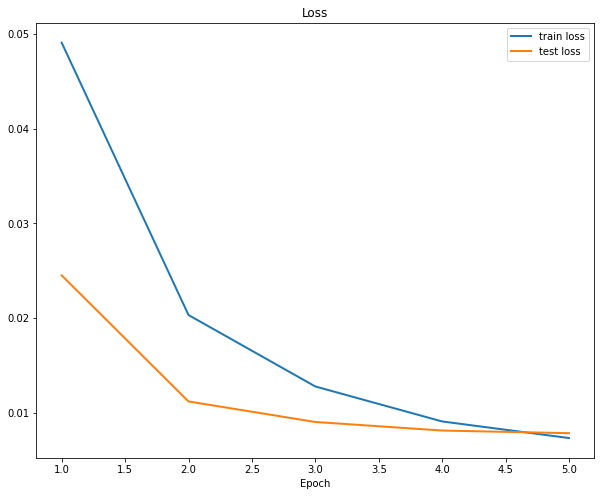

In [29]:
plot_loss_history(vgg_stats[0], vgg_stats[1])

Графики точности на обучающей и тестовой выборке.

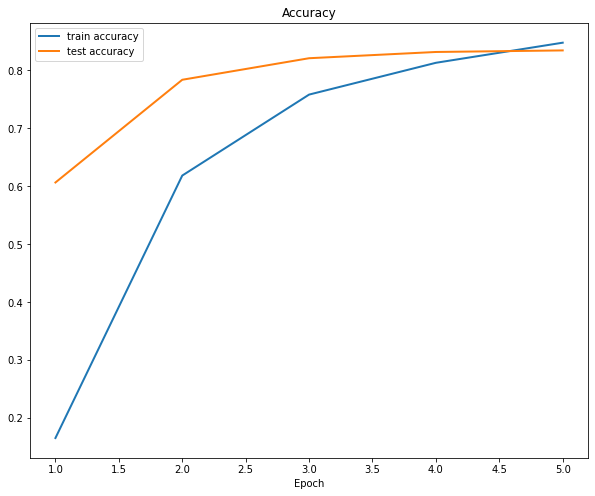

In [30]:
plot_acc_history(vgg_stats[2], vgg_stats[3])

In [41]:
print('Accuracy =', vgg_stats[3][-1])

Accuracy = 0.8345905172413793


### ResNet18

In [33]:
rn = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [35]:
rn.fc = nn.Linear(512, len(classes))

In [36]:
rn = rn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rn.parameters(), lr=1e-4)

epochs = 5

In [37]:
rn_stats = train_model(rn, train_loader, test_loader, epochs, optimizer, criterion, device)

Графики лосса на обучающей и тестовой выборке.

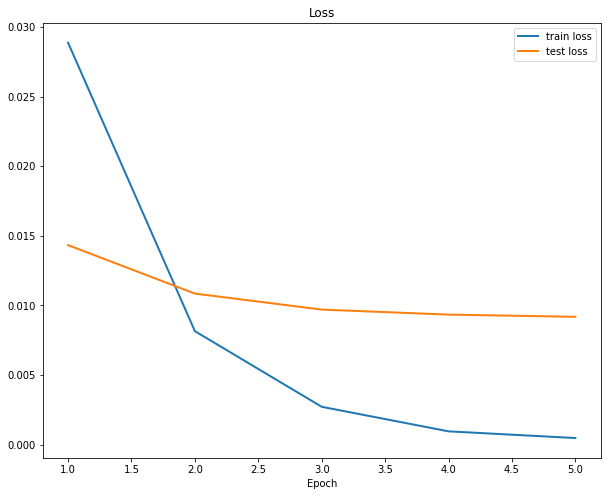

In [38]:
plot_loss_history(rn_stats[0], rn_stats[1])

Графики точности на обучающей и тестовой выборке.

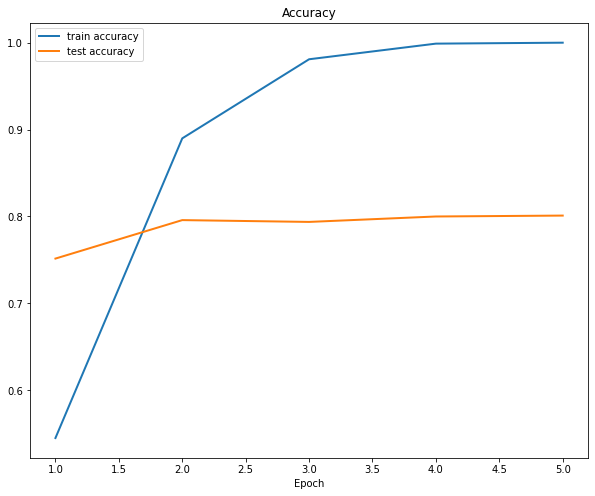

In [39]:
plot_acc_history(rn_stats[2], rn_stats[3])

In [40]:
print('Accuracy =', rn_stats[3][-1])

Accuracy = 0.8010416666666667


Построим для VGG16 матрицу неточности.

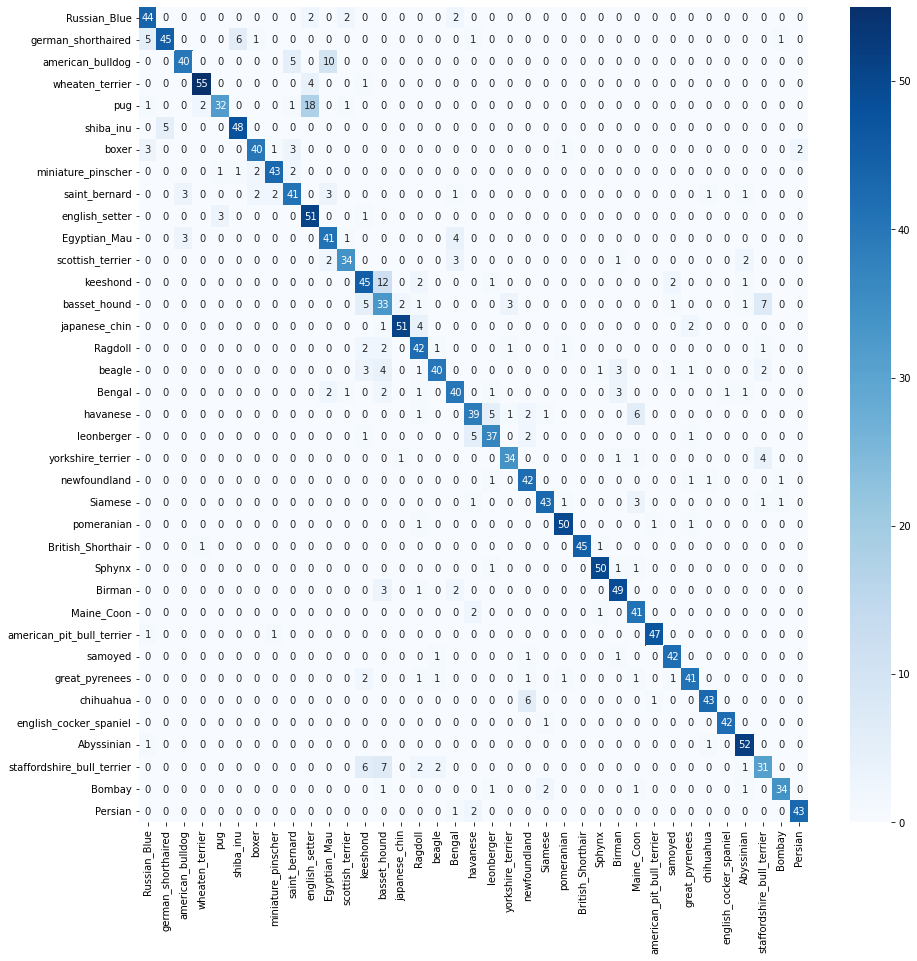

In [43]:
plot_confusion_matrix(vgg, test_loader)

По матрице неточности видим, что модель хорошо справилась с задачей, однако две породы собак (американский бульдог и мопс) она предсказывает хуже, чем остальные.

### Функция подсчёта топ 3 точности

In [44]:
from sklearn.metrics import top_k_accuracy_score

def get_top_k_accuracy(model, val, k):
    preds = None
    reals = None
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            if preds is None:
                preds = y_pred.cpu().numpy()
                reals = y_batch.cpu().numpy()
            else:
                preds = np.vstack([preds, y_pred.cpu().numpy()])
                reals = np.concatenate([reals, y_batch.cpu().numpy()])
    return top_k_accuracy_score(reals, preds, k=k)

In [45]:
get_top_k_accuracy(vgg, test_loader, 3)

0.9664536741214057

Видим, что правильный ответ находится в топ 3 вариантах модели в 97% случаев.

К сожалению, не хватает времени на подсчёт точности бинарной классификации(